In [24]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import datasets

In [25]:
# Load Data from MNIST
(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data()

# Add Channel dimension
X_train = X_train[..., tf.newaxis]
X_test = X_test[..., tf.newaxis]

# Data Normalization
X_train, X_test = X_train/255., X_test/255.

In [32]:
inputs = layers.Input((28, 28, 1))
l = layers.Conv2D(32, (3, 3), padding='SAME')(inputs)
l = layers.Activation('relu')(l)
l = layers.Conv2D(32, (3, 3), padding='SAME')(l)
l = layers.Activation('relu')(l)
l = layers.MaxPool2D(pool_size=(2, 2))(l)
l = layers.Dropout(0.25)(l)

l = layers.Conv2D(64, (3, 3), padding='SAME')(l)
l = layers.Activation('relu')(l)
l = layers.Conv2D(64, (3, 3), padding='SAME')(l)
l = layers.Activation('relu')(l)
l = layers.MaxPool2D(pool_size=(2, 2))(l)
l = layers.Dropout(0.25)(l)

l = layers.Flatten()(l)
l = layers.Dense(512)(l)
l = layers.Activation('relu')(l)
l = layers.Dropout(0.25)(l)
l = layers.Dense(10)(l)
l = layers.Activation('softmax')(l)

model = tf.keras.Model(inputs=inputs, outputs=l, name='cnn-v1')

### tf.data

In [26]:
# Generator
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(1000)
train_ds = train_ds.batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.batch(32)

#### next(iter({generator}))

In [31]:
image, label = next(iter(train_ds))
image.shape, label.shape

(TensorShape([32, 28, 28, 1]), TensorShape([32]))

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

#### train_ds.take()

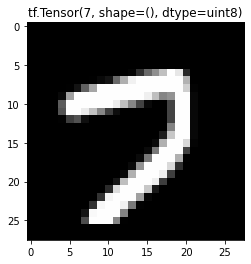

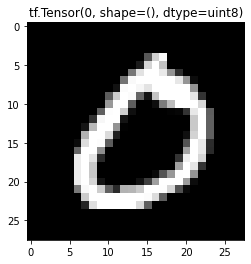

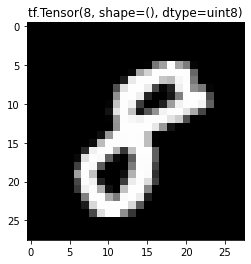

In [28]:
for image, label in train_ds.take(3):
    plt.title(str(label[0]))
    plt.imshow(image[0, :, :, 0], 'gray')
    plt.show()

### Training (Keras)

```Python3
model.compile()
mode.fit()
```

### Optimization
* Loss Function
* Optimizer

In [33]:
loss_function = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

In [34]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

### Training (Expert)
* @tf.function : 기존 session 열었던 것 처럼 바로 작동하는것이 아니고, 그래프만 만든뒤 학습이 시작되면 돌아가도록 함. -> 속도향상

In [35]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_function(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss(loss)
    train_accuracy(labels, predictions)